In [ ]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable

from tensorflow.keras.models import load_model


In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extracts the pathway directories to the valdiation images and masks
validation_image_dir = os.path.join("/path_to/validation_image")
validation_mask_dir = os.path.join("/path_to/validation_mask")


# Get a list of image and mask file paths
validation_image_paths = glob.glob(os.path.join(validation_image_dir, '*.png'))
validation_mask_paths = glob.glob(os.path.join(validation_mask_dir, '*.png'))

# Sort the masks and images to make sure each pair corresponds to each other
validation_image_paths = sorted(validation_image_paths)
validation_mask_paths = sorted(validation_mask_paths)

#checkpoint
print("validation image", len(validation_image_paths))
print("validation mask", len(validation_mask_paths))

validation image 34
validation mask 34


In [ ]:
# Define the function to load image and corresponding maks with tenseflow
def load_image_and_mask(image_path, mask_path):
    # Read the image path as binary data
    image = tf.io.read_file(image_path)
		# Decode the binary image data and specify 3 channels for coloured RGB image
    image = tf.io.decode_png(image,channels=3)
		# Read the corresponding mask path as binary data
    mask = tf.io.read_file(mask_path)
    # Decode the binary mask data and specify 1 channel for segmentation image
    mask = tf.io.decode_png(mask,channels=1)

		# Return a dictionary containing the image file name, image data, and segmentation mask data.
    return {'file_name': image_path, 'image': image, 'segmentation_mask': mask}

In [ ]:
#define the image size
img_size = 256

In [ ]:
# Define RESIZE function
def resize(input_image, input_mask): # Takes image and corresponding mask as inputs
    # Resize the image with tf.resize
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    # Resize the mask with tf.resize
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    return input_image, input_mask


# Define NORMALIZE function
def normalize(input_image, input_mask): # Takes image and corresponding mask as inputs
   # Normalize input image to values 0-1
   input_image = tf.cast(input_image, tf.float32) / 255.0
   # Normalize input mask to values 0-1
   input_mask = tf.cast(input_mask, tf.float32) / 255
   return input_image, input_mask

In [ ]:
# VALIDATION DATASET

# Load data
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths))
validation_dataset = validation_dataset.map(lambda image_path, mask_path: load_image_and_mask(image_path, mask_path))

# Resize
validation_dataset = validation_dataset.map(lambda x: resize(x["image"], x["segmentation_mask"]))

# Normalize
validation_dataset = validation_dataset.map(lambda x, y: normalize(x, y))

In [ ]:
# Prepare Validation batches
validation_batches = validation_dataset.batch(1)

In [ ]:
# Define a function that creates a custom Adam optimizer
def custom_optimizer():
    return tf.keras.optimizers.Adam(
        learning_rate,  # Custom learning rate
        beta_1,           # Custom beta_1
        beta_2,         # Custom beta_2
        epsilon,         # Custom epsilon
    )

# Define loss function and store in keras class
@keras.saving.register_keras_serializable()
# Inherit class from tf.keras.losses.Loss
class DiceLoss(tf.keras.losses.Loss):
    # Initialise the loss function parameters
    def __init__(self, smooth=1, gama=2):
        super(DiceLoss, self).__init__()
        # Name loss function
        self.name = 'NDL'
        # Apply smoothing factor to avois division by zero
        self.smooth = smooth
        # Exponent valye for gama in denominator
        self.gama = gama

    # Call methds to compute the loss
    def call(self, y_true, y_pred):
        # Convert to float32
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)

        # Numerator of the dice loss formula
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        # Denominator of the dice loss formulae
        denominator = tf.reduce_sum(y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        # Compute the final dice loss result
        result = 1 - tf.divide(nominator, denominator)
        return result

# Define dice coefficient metrics
def dice_coefficient_metric(y_true, y_pred, smooth=1):
    # Compute intersection between true and prediction values
    intersection = tf.reduce_sum(y_true * y_pred)
    # Compute denominator
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    # Compute dice coefficient
    dice_coefficient = (2.0 * intersection + smooth) / denominator
    return dice_coefficient

In [ ]:
# Compile the model
unet_model.compile(
    optimizer=custom_optimizer(),# Use custom optimizer (here Adam)
    loss= DiceLoss(),  # Use custom loss function
    metrics=[dice_coefficient_metric])  # Use dice coefficient as a metric

NameError: ignored

Get the mean dice score and standard error of the mean

In [ ]:
# Load trained model
loaded_model = tf.keras.models.load_model("/Pathway_to_save_trained_model",
                                       custom_objects={'DiceLoss': DiceLoss},
                                       compile = False)


# Define function to create binary mask from model prediction
def create_binary_mask(pred_masks):
    # Apply threshold to get binary mask
    binary_masks = tf.where(pred_masks > 0.9, 1.0, 0.0)

    return tf.cast(binary_masks, tf.float32)

# Initialize variables to store total dice score and count of images
total_dice_score = 0
total_images = 0
# Open empty list to append the dice scores to get SEM
data = []


# Loop through validation image and corresponding mask
for image, mask in validation_batches:
    # Predict the masks using the loaded model
    probabilities = loaded_model.predict(image)

    # Get binary predictions
    predicted_mask = create_binary_mask(probabilities)

    # Ensure the same shape
    dice_score = dice_coefficient_metric(mask.numpy(), predicted_mask.numpy())

    #append the dice scores into the list for SEM
    data.append(dice_score)
    #print("Dice Score:", dice_score.numpy())

    # Accumulate dice score and increment image count
    total_dice_score += dice_score.numpy()
    total_images += 1

# Calcuate the mean dice score
mean_dice_score = total_dice_score / total_images
print("Mean Dice Score for all images: {}".format(mean_dice_score))

# Calcuate the SEM
SEM = np.std(data, ddof=1) / np.sqrt(np.size(data))
print("standard error of the mean", SEM)


1/1 [==============================] - 3s 3s/step
Mean Dice Score for all images: 0.8452214993098203
standard error of the mean 0.027743709628439858


View the binary masks from model predictions

1/1 [==============================] - 3s 3s/step


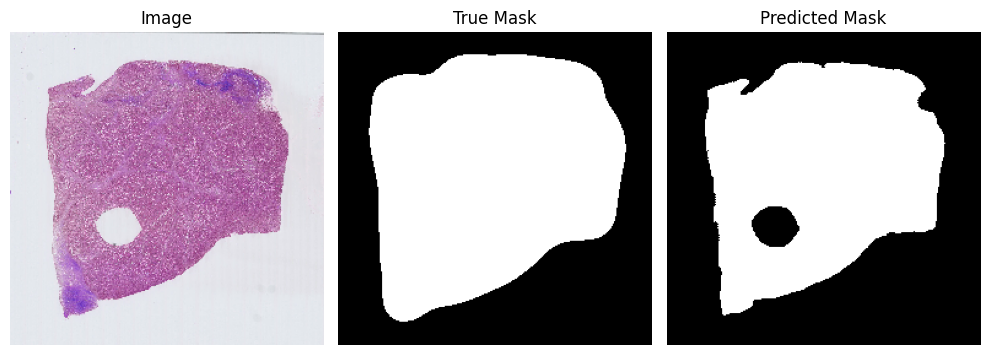

1/1 [==============================] - 2s 2s/step


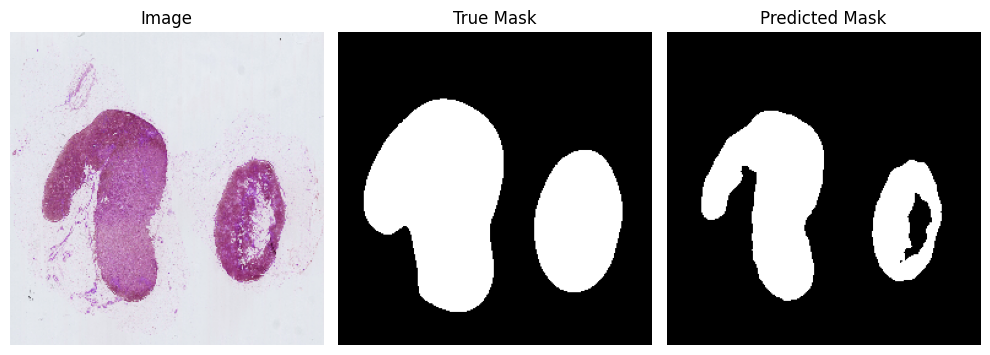

1/1 [==============================] - 2s 2s/step


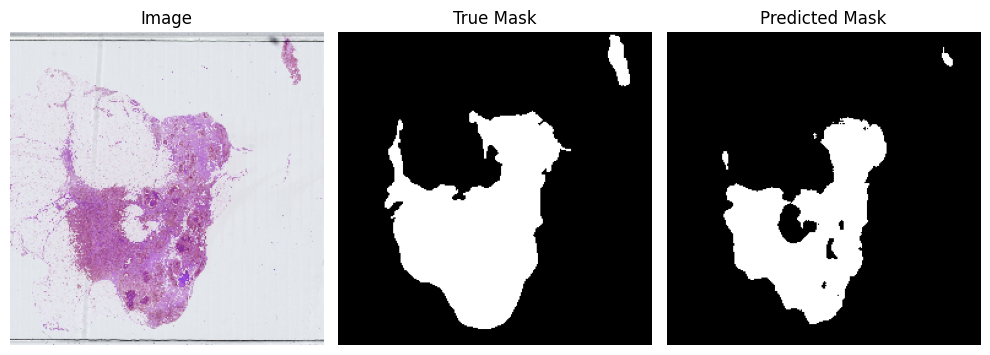

1/1 [==============================] - 2s 2s/step


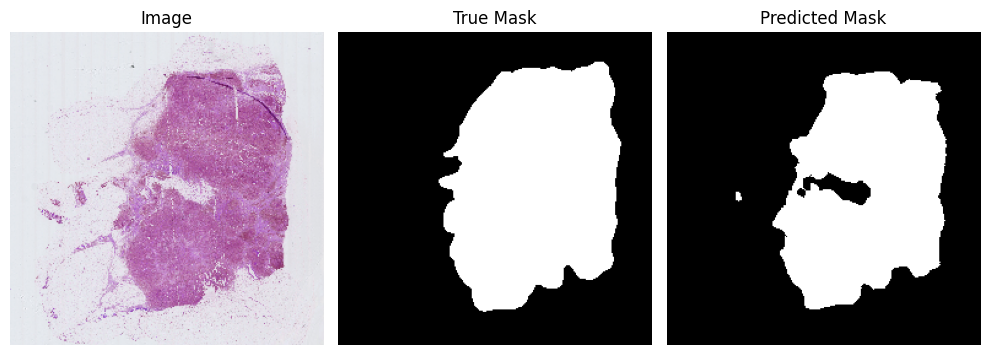

1/1 [==============================] - 3s 3s/step


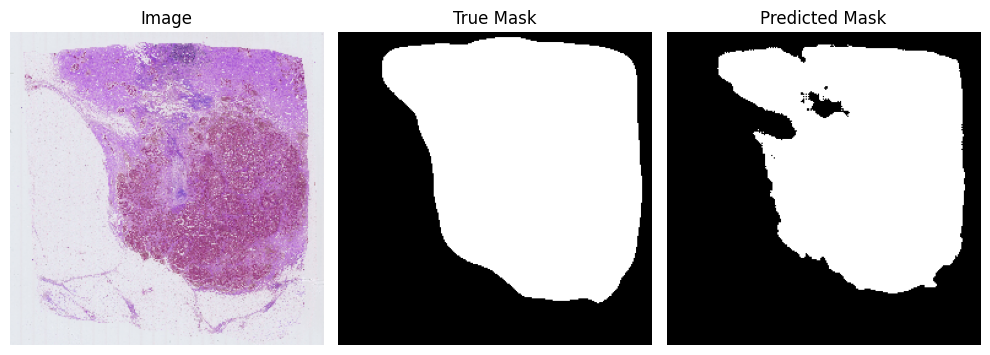

1/1 [==============================] - 2s 2s/step


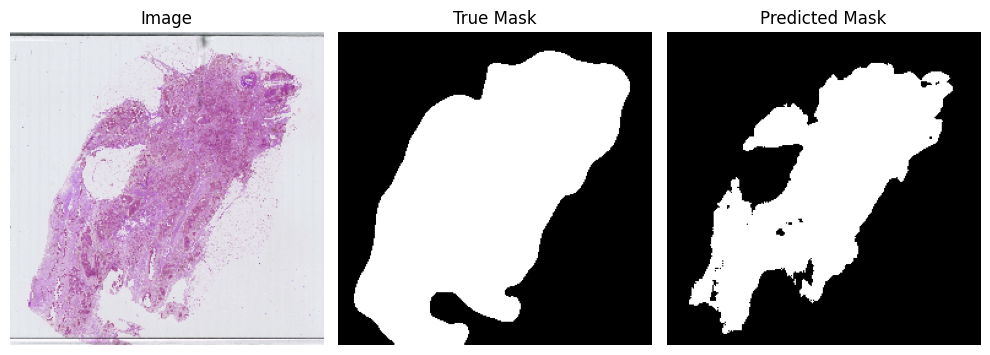

1/1 [==============================] - 2s 2s/step


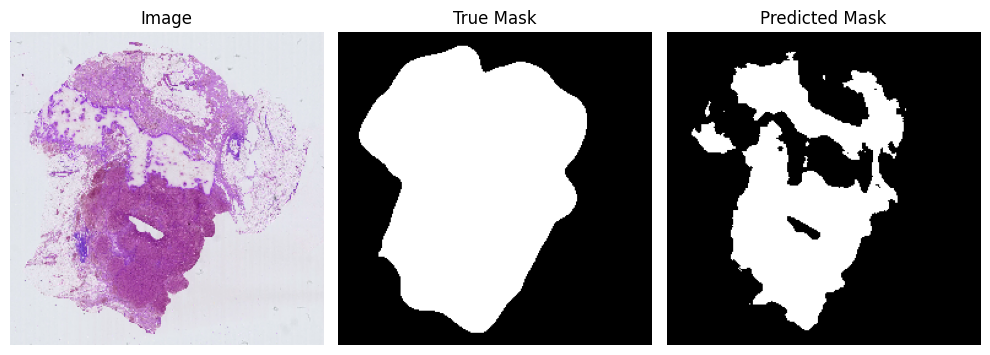

1/1 [==============================] - 2s 2s/step


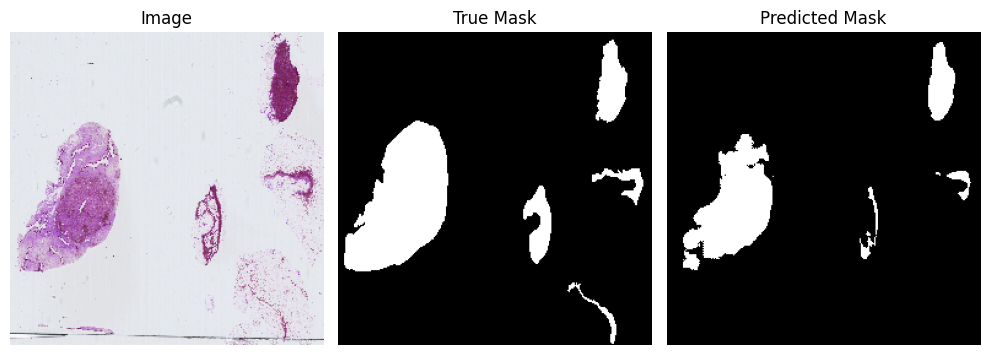

1/1 [==============================] - 2s 2s/step


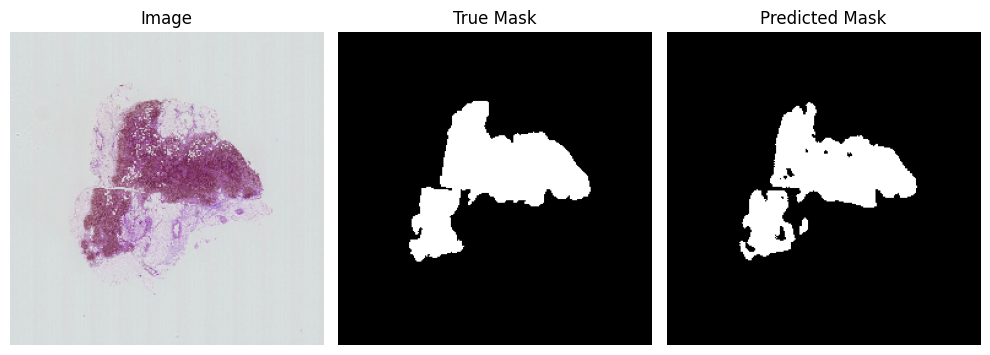

1/1 [==============================] - 3s 3s/step


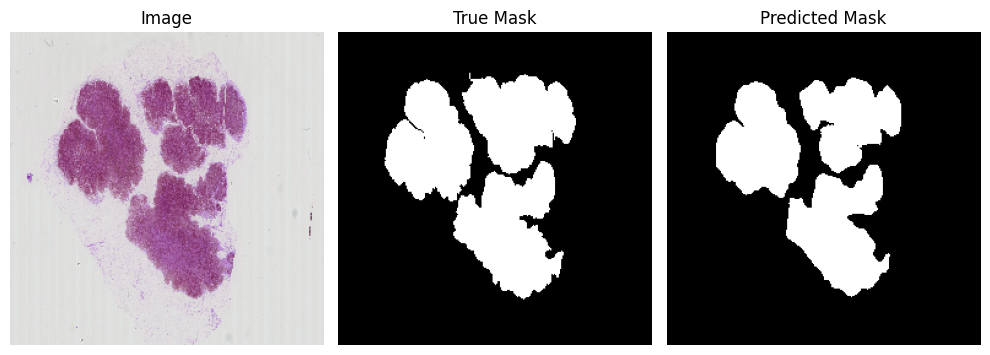

1/1 [==============================] - 3s 3s/step


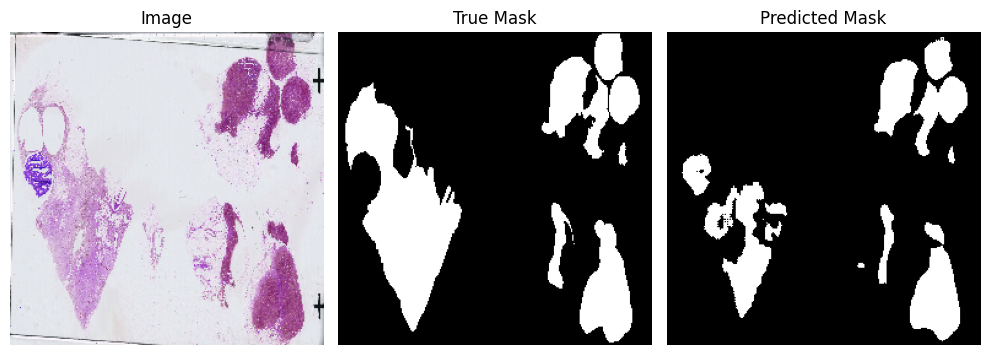

1/1 [==============================] - 2s 2s/step


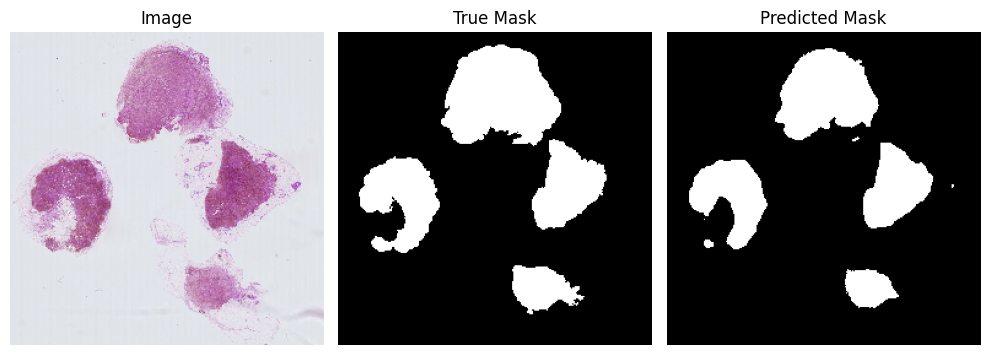

1/1 [==============================] - 2s 2s/step


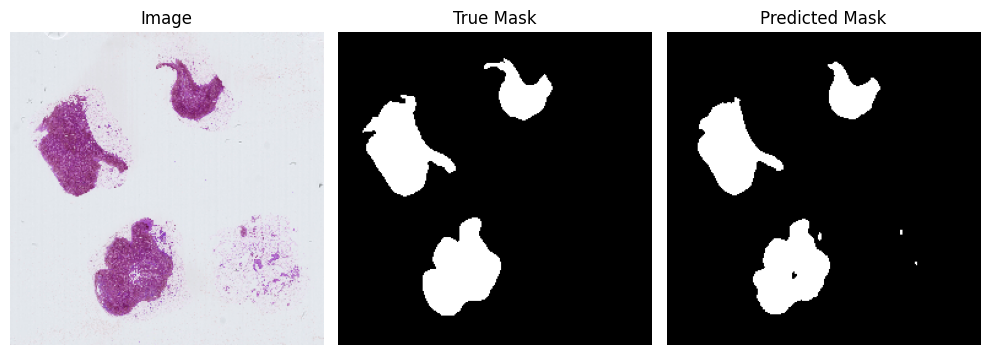

1/1 [==============================] - 2s 2s/step


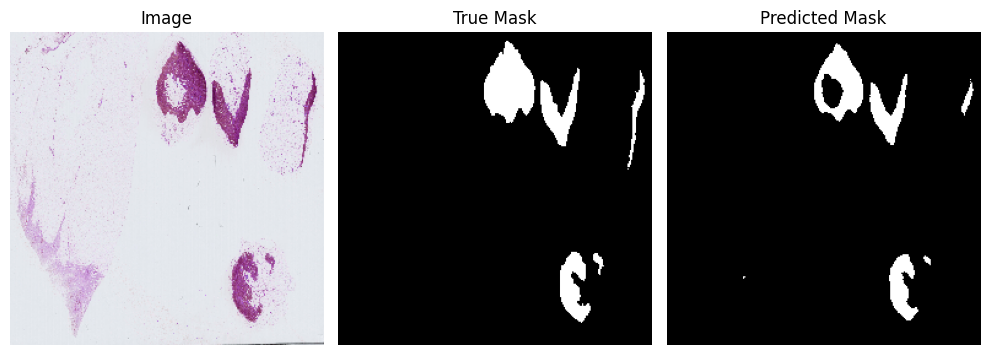

1/1 [==============================] - 3s 3s/step


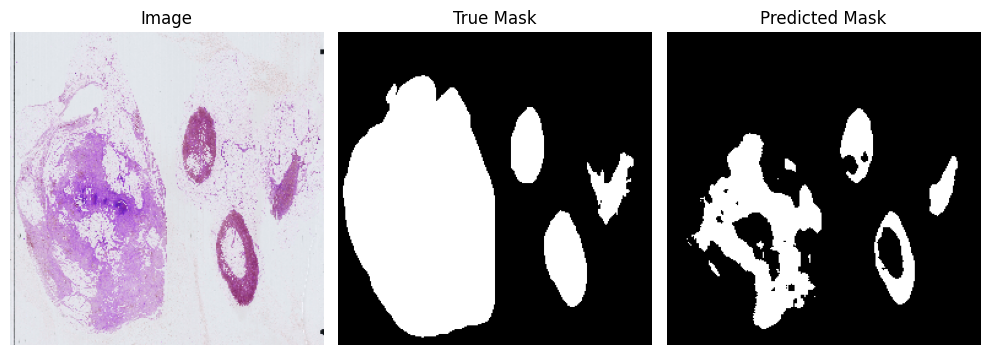

1/1 [==============================] - 3s 3s/step


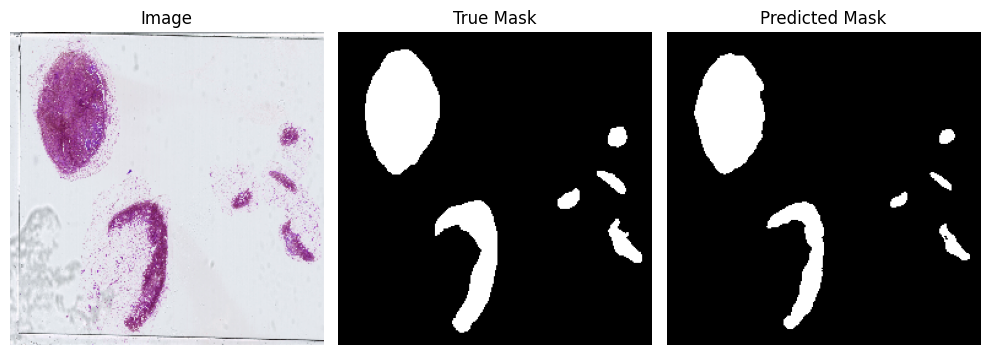

1/1 [==============================] - 3s 3s/step


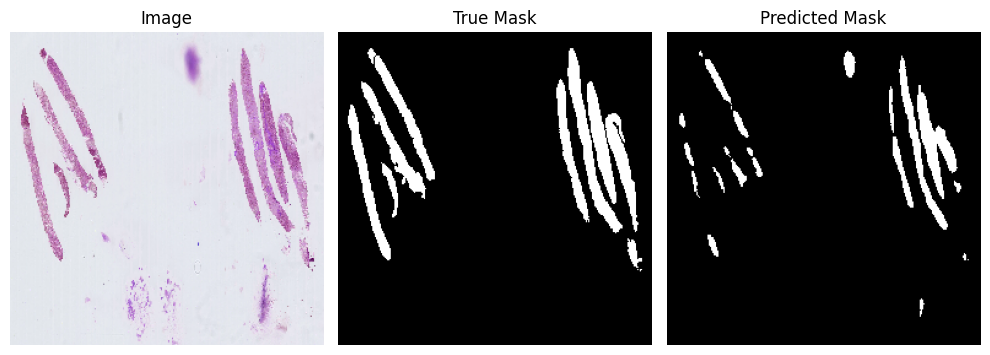

1/1 [==============================] - 2s 2s/step


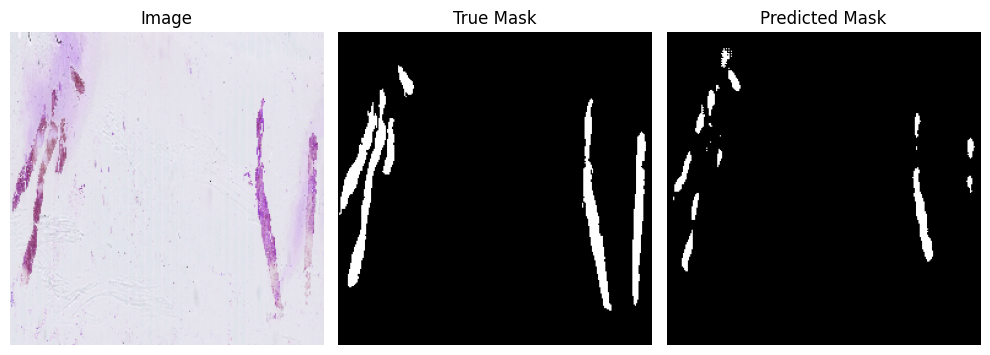

1/1 [==============================] - 2s 2s/step


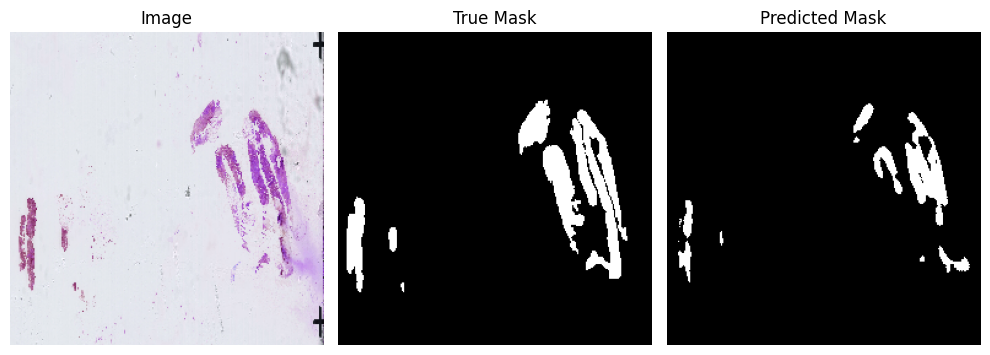

1/1 [==============================] - 2s 2s/step


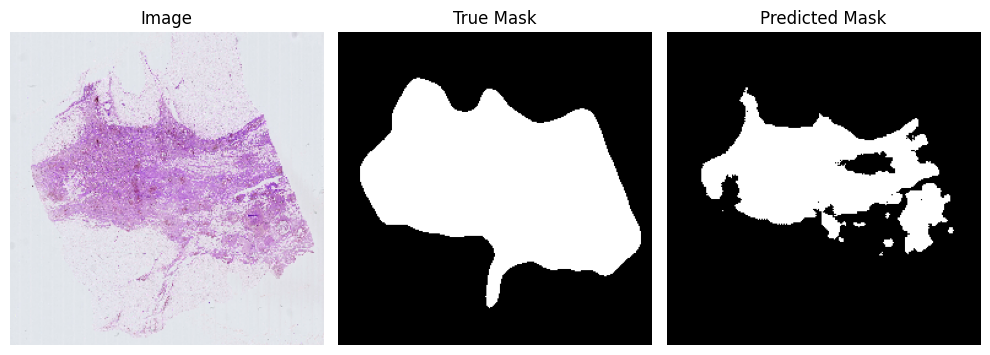

1/1 [==============================] - 2s 2s/step


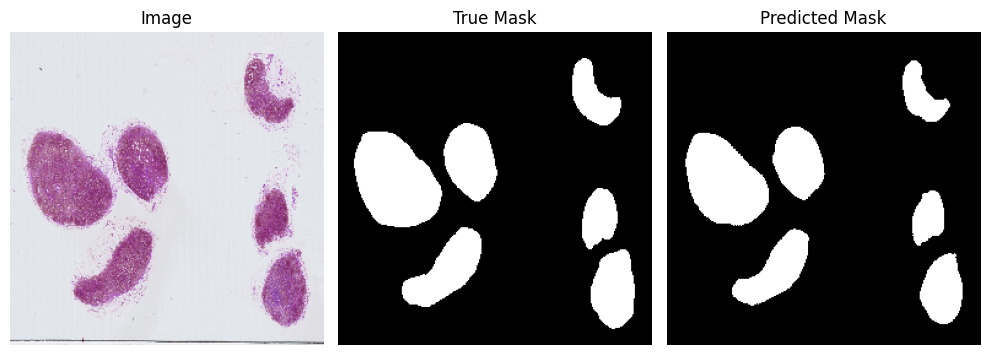

1/1 [==============================] - 3s 3s/step


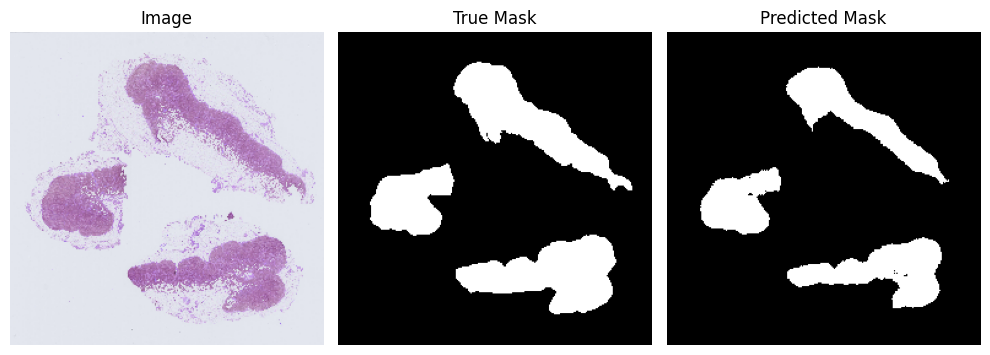

1/1 [==============================] - 3s 3s/step


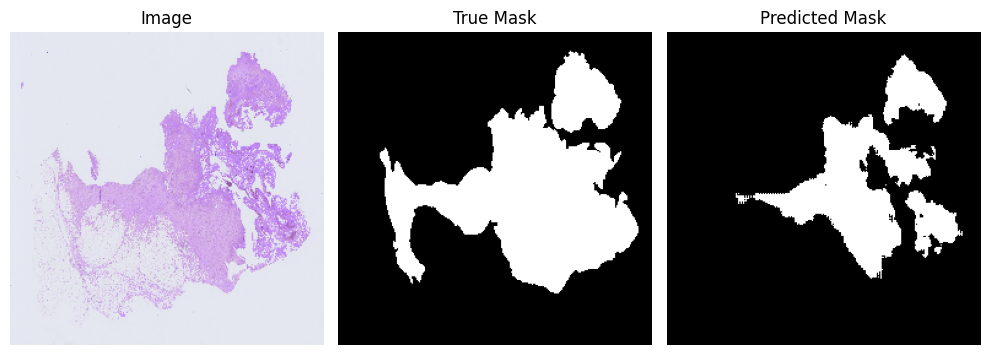

1/1 [==============================] - 3s 3s/step


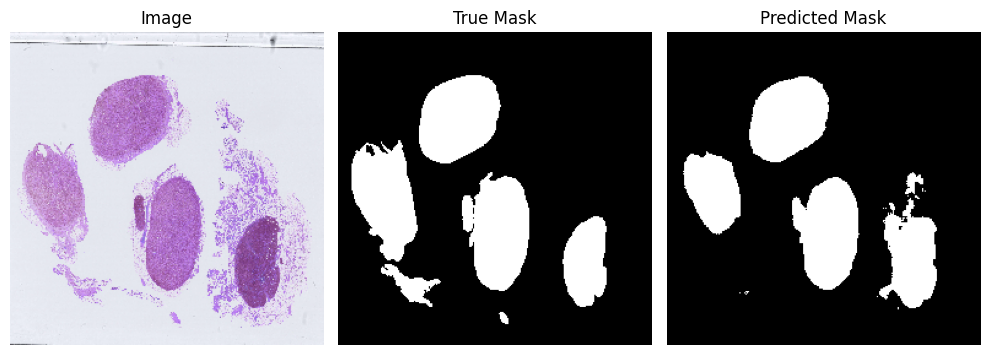

1/1 [==============================] - 2s 2s/step


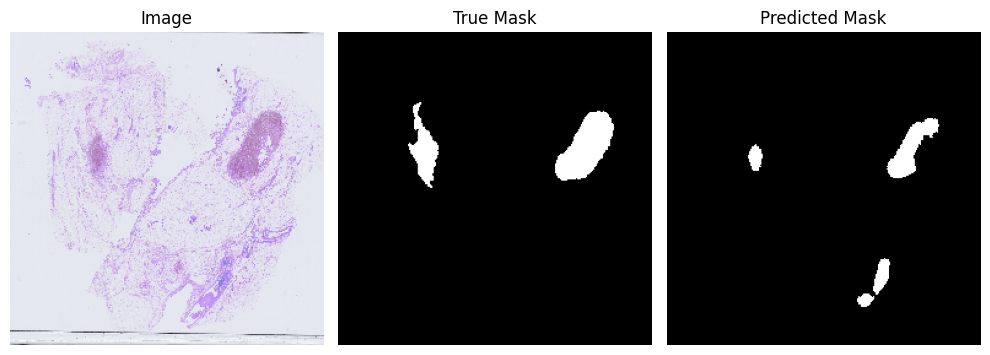

1/1 [==============================] - 2s 2s/step


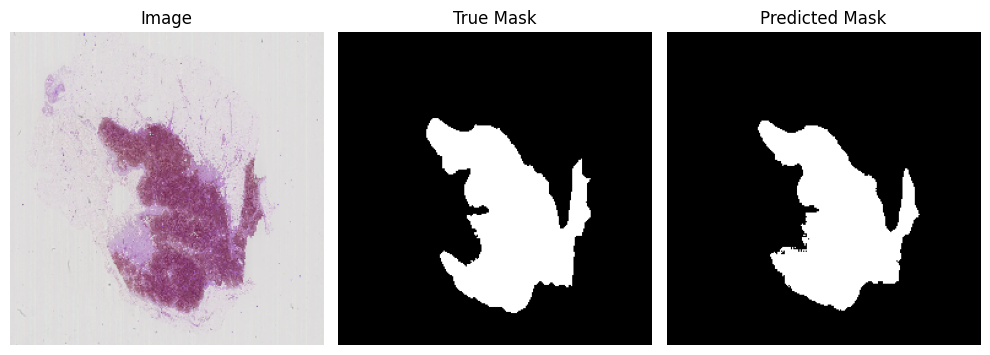

1/1 [==============================] - 3s 3s/step


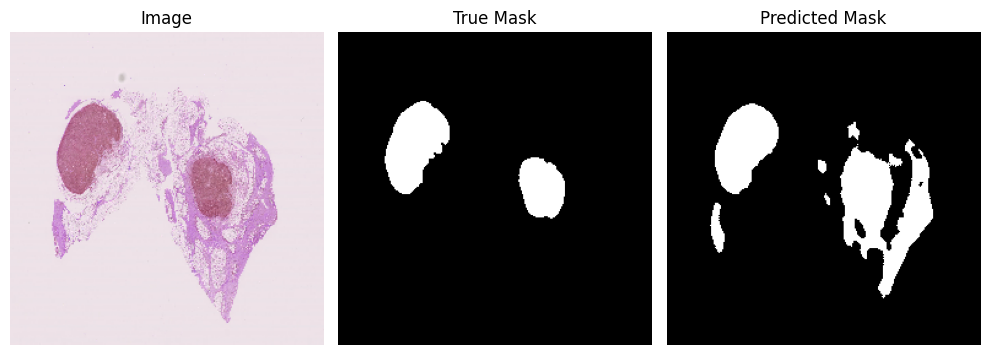

1/1 [==============================] - 3s 3s/step


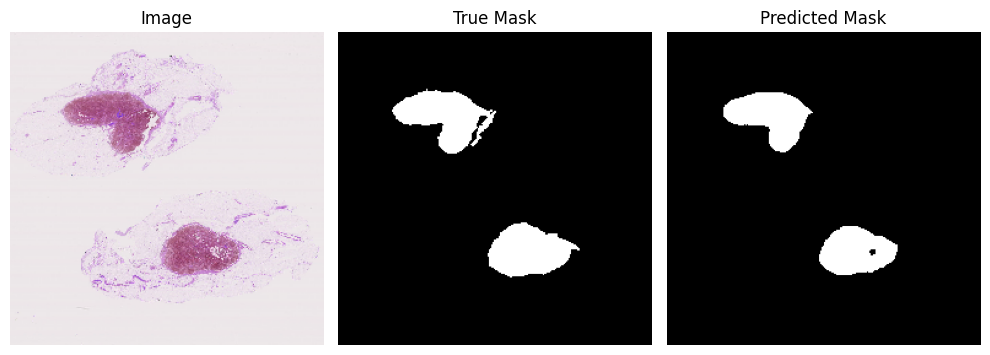

1/1 [==============================] - 2s 2s/step


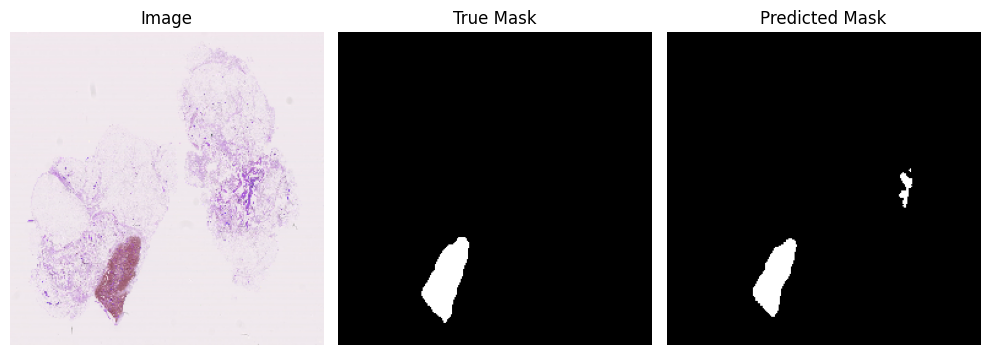

1/1 [==============================] - 2s 2s/step


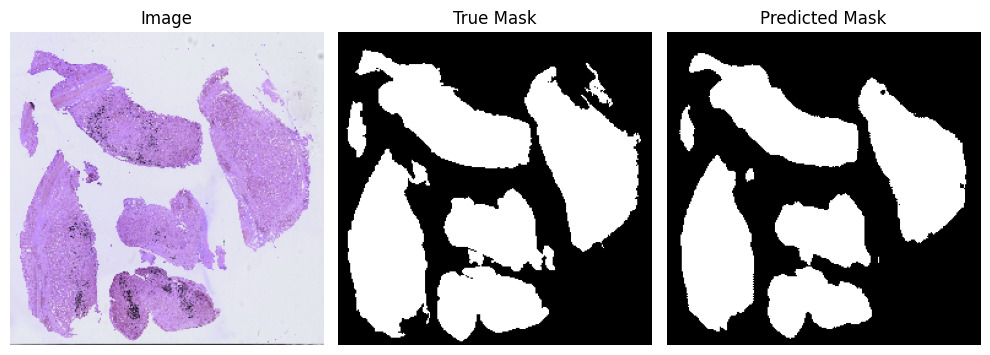

1/1 [==============================] - 2s 2s/step


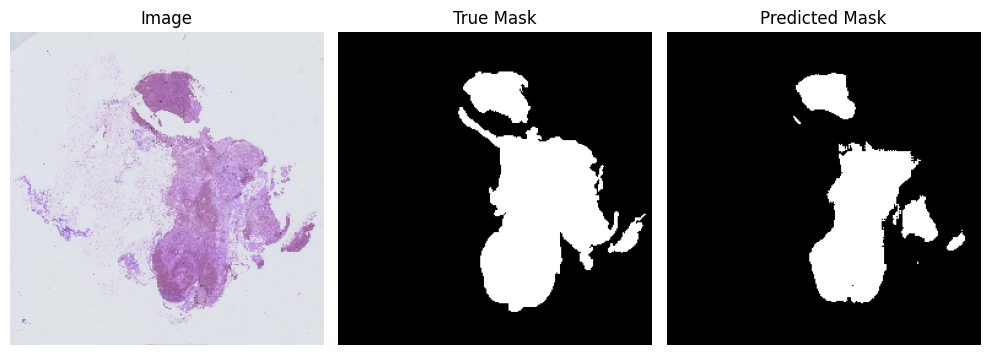

1/1 [==============================] - 2s 2s/step


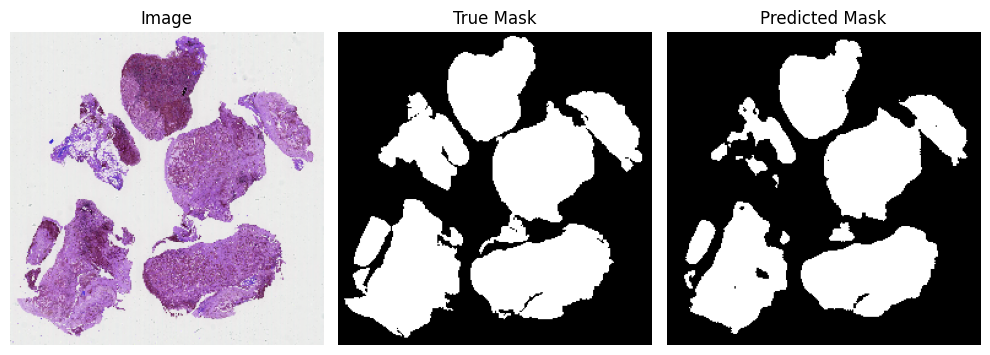

1/1 [==============================] - 3s 3s/step


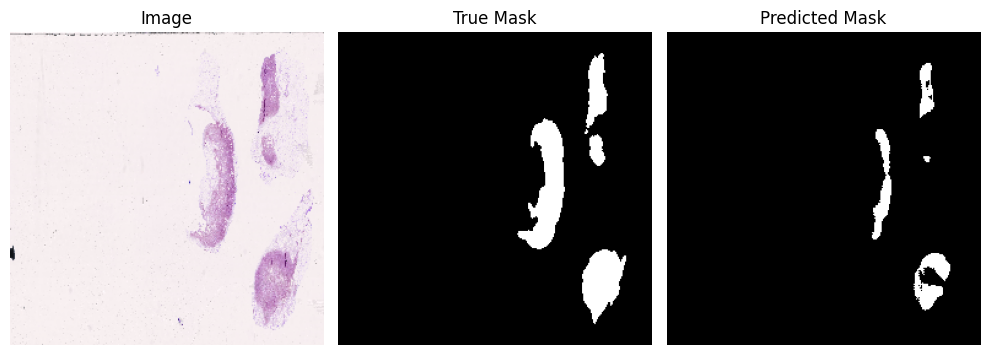

1/1 [==============================] - 3s 3s/step


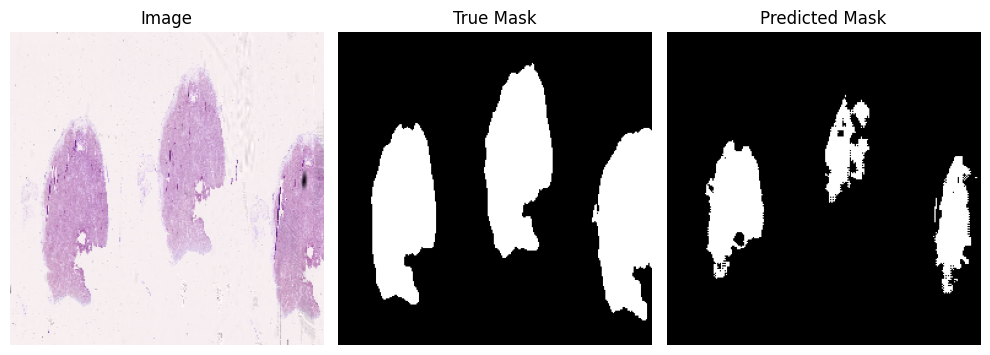

In [ ]:
# Load trained model
loaded_model = tf.keras.models.load_model("/Pathway_to_save_trained_model",
                                       custom_objects={'DiceLoss': DiceLoss},
                                       compile = False)

# Define function to generate binary mask from model prediction
def create_binary_mask(pred_masks):
    # Apply threshold to get binary mask
    binary_masks = tf.where(pred_masks > 0.9, 1, 0)
    return tf.cast(binary_masks, tf.uint8)


# Define function to display the corresponding image, true mask and predicted mask
def display_image_with_mask(image, true_mask, predicted_mask):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 12))

    # Display the image
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    # Display the true mask as greyscale
    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title("True Mask")
    axes[1].axis('off')

    # Display the predicted mask as greyscale
    axes[2].imshow(predicted_mask, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Display the plots
    plt.show()


# Loop through each validatio image and corresponding mask
for image, mask in validation_batches:
    # Predict the masks using the loaded model
    probabilities = loaded_model.predict(image)

    # Get binary predictions
    binary_masks = create_binary_mask(probabilities)

    # Display the images with true and predicted masks
    display_image_with_mask(image[0,:,:,:], mask[0,:,:,0], binary_masks[0,:,:])